In [189]:
import argparse
import os
import os.path as osp

from mmengine.config import Config, DictAction
from mmengine.runner import Runner

In [190]:
cfg = Config.fromfile("/opt/ml/level2_cv_semanticsegmentation-cv-15/mmsegmentation/configs/hype_custom/seg_former.py")

In [191]:
cfg.launcher = 'none'

In [192]:
cfg.work_dir ='/opt/ml/level2_cv_semanticsegmentation-cv-15/mmsegmentation/exp/segformer_1024'

In [193]:
cfg.load_from = '/opt/ml/level2_cv_semanticsegmentation-cv-15/mmsegmentation/exp/segformer_1024/iter_32000.pth'

In [194]:
runner = Runner.from_cfg(cfg)

06/16 16:01:01 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.3 (main, Apr 19 2023, 23:54:32) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 624439302
    GPU 0: Tesla V100-PCIE-32GB
    CUDA_HOME: None
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,cod

/opt/conda/envs/py3113/lib/python3.11/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


06/16 16:01:07 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/16 16:01:07 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/opt/ml/level2_cv_semanticsegmentation-cv-15/mmsegmentation/mmseg/models/builder.py:42: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn(
/opt/ml/level2_cv_semanticsegmentation-cv-15/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:245: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/opt/ml/level2_cv_semanticsegmentation-cv-15/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:63: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn(


In [195]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [196]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [197]:
CLASSES = [
    "finger-1",
    "finger-2",
    "finger-3",
    "finger-4",
    "finger-5",
    "finger-6",
    "finger-7",
    "finger-8",
    "finger-9",
    "finger-10",
    "finger-11",
    "finger-12",
    "finger-13",
    "finger-14",
    "finger-15",
    "finger-16",
    "finger-17",
    "finger-18",
    "finger-19",
    "Trapezium",
    "Trapezoid",
    "Capitate",
    "Hamate",
    "Scaphoid",
    "Lunate",
    "Triquetrum",
    "Pisiform",
    "Radius",
    "Ulna",
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [326]:
from collections import defaultdict
from mmengine.dataset import Compose
import numpy as np


def _preprare_data(imgs, model):
    for t in cfg.test_pipeline:
        if t.get('type') in ['LoadXRayAnnotations', 'TransposeAnnotations']:
            cfg.test_pipeline.remove(t)

    is_batch = True
    if not isinstance(imgs, (list, tuple)):
        imgs = [imgs]
        is_batch = False

    if isinstance(imgs[0], np.ndarray):
        cfg.test_pipeline[0]['type'] = 'LoadImageFromNDArray'

    # TODO: Consider using the singleton pattern to avoid building
    # a pipeline for each inference
    pipeline = Compose(cfg.test_pipeline)

    data = defaultdict(list)
    for img in imgs:
        if isinstance(img, np.ndarray):
            data_ = dict(img=img)
        else:
            data_ = dict(img_path=img)
        data_ = pipeline(data_)
        data['inputs'].append(data_['inputs'])
        data['data_samples'].append(data_['data_samples'])

    return data, is_batch

In [371]:
import torch
import cv2
from tqdm.auto import tqdm
import torch.nn.functional as F



def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = 29

        for step, test_dict in tqdm(enumerate(data_loader), total=len(data_loader)):
            image_name = osp.join(test_dict['data_samples'][0].img_path.split('/')[7], test_dict['data_samples'][0].img_path.split('/')[8])
            img = cv2.imread(test_dict['data_samples'][0].img_path)
            
            data, is_batch = _preprare_data(img, model)
            
            results = model.test_step(data)
            
            outputs = results[0].pred_sem_seg.data
            
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for c, segm in enumerate(outputs):
                rle = encode_mask_to_rle(segm)
                rles.append(rle)
                filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [328]:
from mmengine.registry import MODELS

model = MODELS.build(cfg.model)

/opt/ml/level2_cv_semanticsegmentation-cv-15/mmsegmentation/mmseg/models/builder.py:42: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn(
/opt/ml/level2_cv_semanticsegmentation-cv-15/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:245: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [329]:
test_dataloader = runner.build_dataloader(cfg.test_dataloader)

In [330]:
model_path = os.path.join(cfg.work_dir, "iter_32000.pth")

In [332]:
from mmengine.runner import load_checkpoint

checkpoint = load_checkpoint(model, model_path, map_location="cpu")

Loads checkpoint by local backend from path: /opt/ml/level2_cv_semanticsegmentation-cv-15/mmsegmentation/exp/segformer_1024/iter_32000.pth


In [372]:
rles, filename_and_class = test(model, test_dataloader)

100%|██████████| 300/300 [05:18<00:00,  1.06s/it]


In [373]:
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [374]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [375]:
import cv2
IMAGE_ROOT = "/opt/ml/input/data/test/DCM"

image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[1].split("_")[1]))

In [376]:
import numpy as np

preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

In [377]:
preds.shape

(29, 2048, 2048)

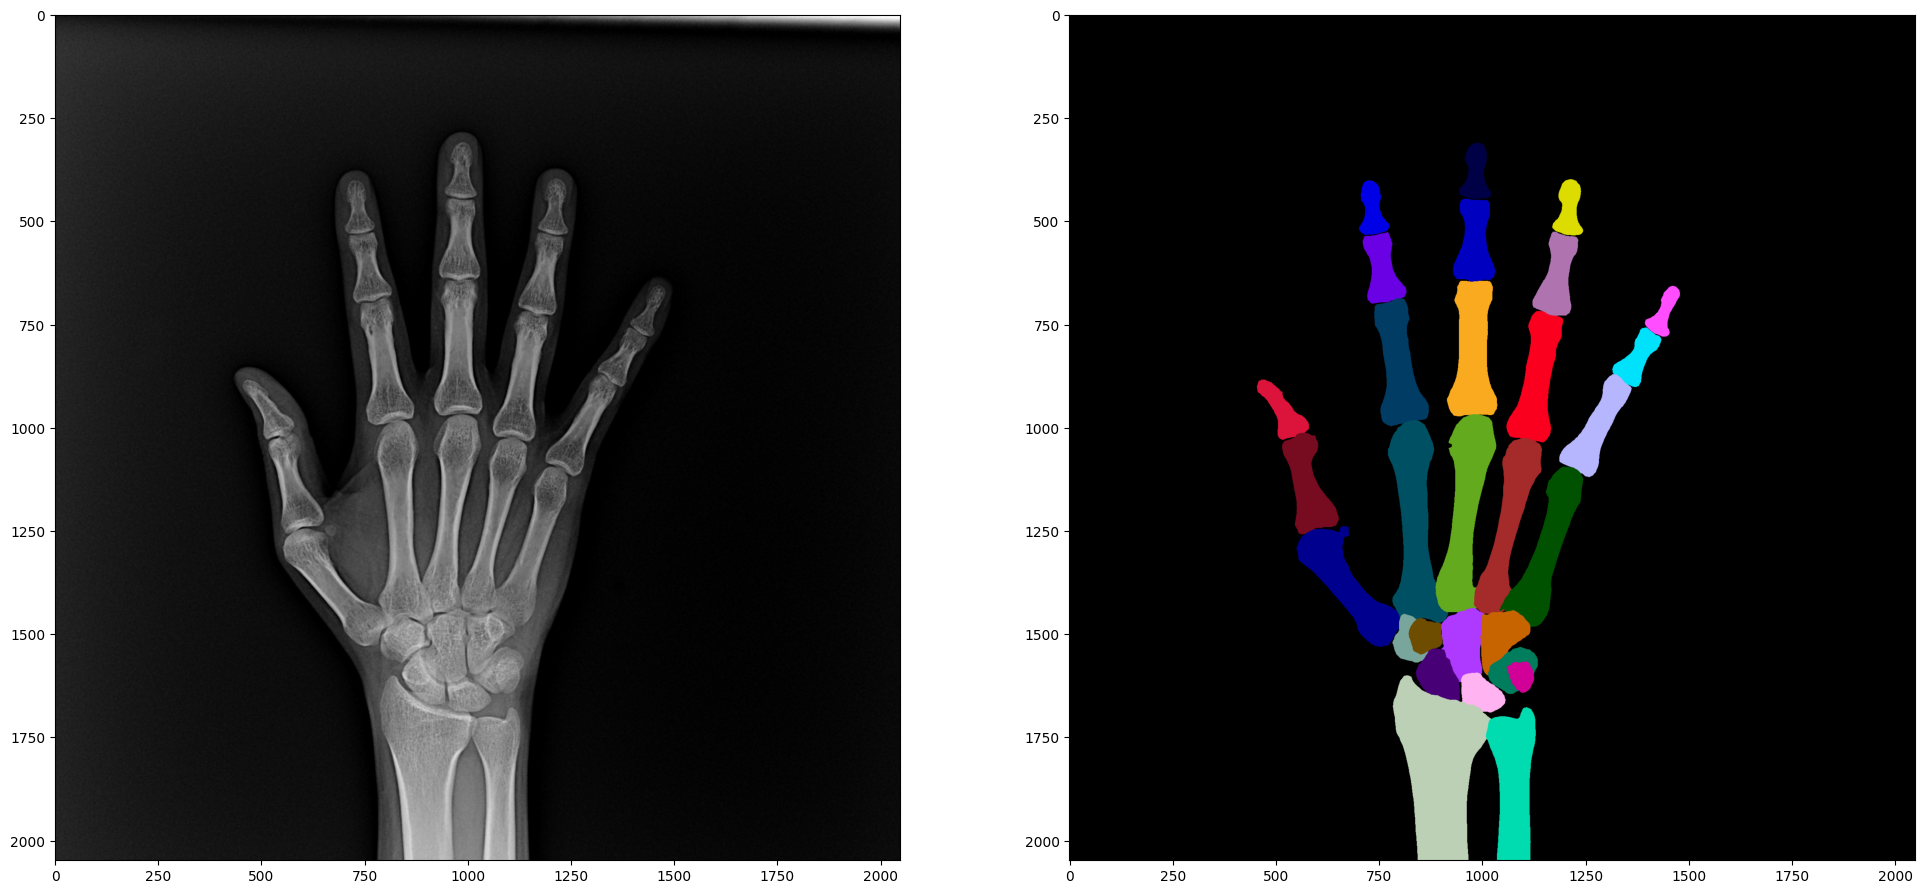

In [378]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

In [379]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

In [380]:
image_name = [os.path.basename(f) for f in filename]

In [382]:
import pandas as pd

df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

In [383]:
df.head(30)

,image_name,class,rle
0,image1661319116107.png,finger-1,1812947 9 1814993 13 1817038 18 1819085 21 182...
1,image1661319116107.png,finger-2,2075195 1 2077233 15 2079277 24 2081323 28 208...
2,image1661319116107.png,finger-3,2540183 11 2542228 17 2544275 19 2546322 20 25...
3,image1661319116107.png,finger-4,826067 11 828112 17 830158 21 832205 23 834252...
4,image1661319116107.png,finger-5,1082114 3 1084159 7 1086202 13 1088244 19 1090...
5,image1661319116107.png,finger-6,1409820 9 1411865 18 1413910 23 1415956 26 141...
6,image1661319116107.png,finger-7,2014017 8 2016058 21 2018102 27 2020147 32 202...
7,image1661319116107.png,finger-8,639959 14 642004 19 644050 23 646097 25 648143...
8,image1661319116107.png,finger-9,916412 12 918458 18 920504 26 922551 48 922607...
9,image1661319116107.png,finger-10,1323957 16 1324000 24 1326004 24 1326036 40 13...


In [384]:
df.to_csv("output.csv", index=False)